# Walkthrough del uso de `difusion_lib` 

Este cuaderno explica **cómo usar la librería modular `difusion_lib`** para:
- Difundir masa en grafos mediante el motor de difusión.
- Analizar componentes (fuertemente) conexas y su impacto global.
- Ejecutar el proceso iterativo de *pelado* (reducción de red por masa).
- **Generar Dashboards 3D interactivos** (HTML) con selector de capas.
- Exportar resultados a formatos PNG, GEXF (Gephi) y CSV.

> **Instalación**: Asegúrate de haber instalado la librería en modo editable ejecutando `pip install -e .` en la raíz del proyecto.


## 1. Importaciones

Gracias a la estructura modular y al archivo `__init__.py`, podemos importar las clases principales directamente desde la raíz del paquete.


In [1]:
import networkx as nx
import pandas as pd

# Importación desde el paquete modular
from difusion_lib import (
    MotorDifusion,
    AnalizadorPelado,
    VisualizadorPelado,
    ControladorPelado
)


## 2. Crear un grafo de ejemplo

Generamos un grafo dirigido sintético para probar la dinámica de masa.


In [2]:
G = nx.DiGraph()
G.add_edges_from([
    (1, 2), (2, 3), (3, 1), # Ciclo 1
    (3, 4),                 # Puente
    (4, 5), (5, 4),         # Ciclo 2
    (5, 6)                  # Sumidero
])

# Inicializar masa
for n in G.nodes():
    G.nodes[n]['val'] = 1.0

print(f"Grafo creado con {G.number_of_nodes()} nodos.")


Grafo creado con 6 nodos.


## 3. Difusión de masa (`MotorDifusion`)

Configuramos la tasa de difusión (porcentaje de masa que sale de cada nodo) y el número de iteraciones.


In [3]:
motor = MotorDifusion(G, tasa_difusion=0.5)
motor.ejecutar(iteraciones=20)

# Ver masa acumulada tras difusión
pd.Series(nx.get_node_attributes(G, 'val'), name="Masa").to_frame()

,Masa
1,0.091569
2,0.115370
3,0.145357
4,0.321083
5,0.385595
6,4.941025


## 4. Análisis de componentes (`AnalizadorPelado`)

Identificamos las Componentes Fuertemente Conexas (CFC) y medimos su masa total.


In [4]:
metricas = AnalizadorPelado.obtener_metricas_cfc(
    G,
    version_pelado=0,
    total_nodos_original=len(G.nodes())
)

pd.DataFrame(metricas)

,capa_pelado,id_componente,nodos,tamano,es_trivial,masa_total,impacto_global
0,1,P1_C0,[6],1,True,4.941025,0.823504
1,1,P1_C1,"[4, 5]",2,False,0.706678,0.117780
2,1,P1_C2,"[1, 2, 3]",3,False,0.352296,0.058716


## 5. Visualización (`VisualizadorPelado`)

La clase permite exportar el grafo en múltiples formatos:
- **2D**: PNG con escala de colores según masa.
- **3D**: Gráfico interactivo de Plotly.
- **Gephi**: Archivo GEXF para análisis profesional.


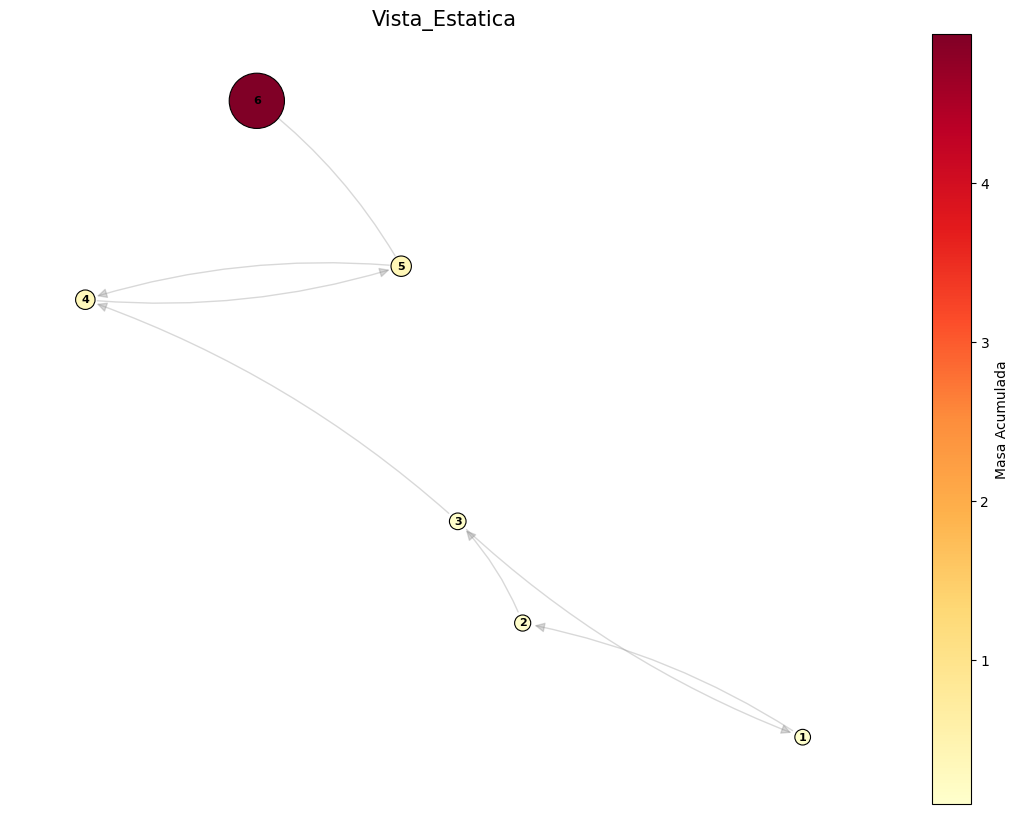

In [5]:
ruta = "test_notebook"

# Renderizado 2D
VisualizadorPelado.renderizar(
    G, 
    titulo="Vista_Estatica", 
    ruta_base=ruta, 
    mostrar_grafico=True
)

# Renderizado 3D Interactivo (Genera un archivo HTML)
VisualizadorPelado.renderizar_3d(
    G, 
    titulo="Vista_Interactiva_3D", 
    ruta_base=ruta
)


## 6. Automatización del Pelado (`ControladorPelado`)

El controlador gestiona el ciclo de vida: Difusión -> Análisis -> Eliminación de componentes pesadas -> Nueva Capa.


In [6]:
controlador = ControladorPelado(G)

resumen = controlador.ejecutar_estudio_pelado(
    num_pelados=5,
    iteraciones_por_pelado=100,
    umbral_masa=1.5,
    tasa_difusion=0.7,
    exportar_resultados=True,
    carpeta_exportacion="estudio_completo"
)

print(f"Se eliminaron {len(resumen)} componentes pesadas.")


Iniciando Estudio: 6 nodos.
Pelado 1: Eliminando 1 componentes.
Pelado 2: Eliminando 1 componentes.
Pelado 3: Eliminando 1 componentes.
Se eliminaron 3 componentes pesadas.


## 7. Estructura de Salida

Tras ejecutar el estudio, la carpeta `estudio_completo/` contendrá:
- `reportes_datos/`: CSVs con la masa de cada nodo en cada iteración.
- `imagenes_grafos/`: Imágenes PNG de cada etapa.
- `archivos_gephi/`: Redes en formato GEXF.
- `dashboard_interactivo.html`: Un archivo único con todas las capas 3D y selector de botones.
- `reporte_resumen_pelado.csv`: Estadísticas finales de todos los componentes eliminados.
